In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit

In [4]:
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from C:\Users\Emma\Desktop\analysis\2020\12\28\run0\run0-datamodel.p


#### View avg frames data w ROIs: 
<img src="reporters/avg_frame_reporter/avg_frame_reporter - point_00.png">

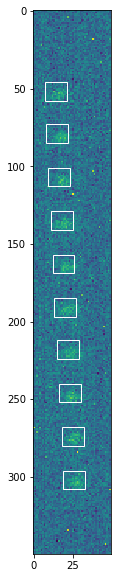

In [143]:
# look at ROIs up close if u want: 
frame_num = 3;
point_num = 0; 
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.imshow(datamodel.get_data(f'frame-{frame_num:02d}_avg',point_num)['mean'])
roi_list = datamodel.datatool_dict['avg_frame_reporter'].roi_dict[f'frame-{frame_num:02d}_avg']
for roi in roi_list: 
    horizontal_slice = roi[1]
    horizontal_span = horizontal_slice.stop - horizontal_slice.start
    vertical_slice = roi[0]
    vertical_span = vertical_slice.stop - vertical_slice.start
    rect = Rectangle((horizontal_slice.start, vertical_slice.start), horizontal_span, vertical_span,
                                 linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)

In [104]:
cav_odt_int_list = [1,2,3,4,5,6]
pzt_para_list = [5]
num_points = datamodel.num_points #len(pzt_para_list) * len(cav_odt_int_list)

tweezer_freq_list = [107,108,109,110,111,112,113,114,115,116]
num_tweezers = 10 #len(tweezer_freq_list)

mol_freq_list = [4, 4, 4.5, 5, 5.5, 6, 6.25, 6.5, 6.75, 7, 7.2, 7.4, 7.6, 7.8, 8]
num_frames = 17 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

print(num_points,'points')
print(num_frames,'frames')
print(num_shots,'shots')

t_exposure = 500

6 points
17 frames
6000 shots


In [130]:
# built counts_dict from counts_array_all: 

counts_array_all = np.empty([num_shots, num_frames, num_tweezers])
for frame_num in range(num_frames):
    tweezer_num=0
    for tweezer_freq in tweezer_freq_list:
        counts_array_all[:,frame_num,tweezer_num]=\
            datamodel.get_data(f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts',range(num_shots))
        tweezer_num+=1
print(counts_array_all.shape)

counts_dict = dict()
for shot in range(num_shots):
    point = shot % num_points
    loop = shot // num_points
    if point not in counts_dict:
        counts_dict[point] = dict()
    for frame_num in range(num_frames):
        if frame_num not in counts_dict[point]:
            counts_dict[point][frame_num]=dict()
        for twz_counter in range(len(tweezer_freq_list)):
            if twz_counter not in counts_dict[point][frame_num]:
                counts_dict[point][frame_num][twz_counter]=[]   
            counts = counts_array_all[shot, frame_num, twz_counter]
            counts_dict[point][frame_num][twz_counter].append(counts)

(6000, 17, 10)


In [134]:
# built counts_dict directly: 

counts_dict = dict()
for point in range(num_points):
    if point not in counts_dict:
        counts_dict[point] = dict()
    for frame_num in range(num_frames):
        if frame_num not in counts_dict[point]:
            counts_dict[point][frame_num]=dict()
        for twz_counter in range(len(tweezer_freq_list)):
            if twz_counter not in counts_dict[point][frame_num]:
                counts_dict[point][frame_num][twz_counter]=[]   
            counts_dict[point][frame_num][twz_counter] =\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point)

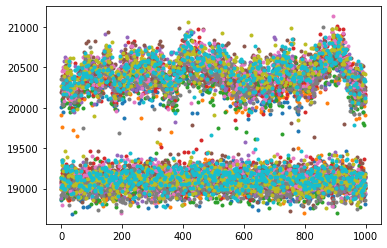

In [133]:
# random test of get_data and showing it: 
for frame_num in range(4,5):
    for tweezer_num in range(num_tweezers):
        plt.plot(datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts',0),'.')
# plt.plot(counts_array_all[:,0,1],'.')
# plt.plot(counts_array_all[:,0,2],'.')

In [179]:
num_loops = num_shots // num_points
roi_area = (roi_list[0][0].stop-roi_list[0][0].start)*(roi_list[0][1].stop-roi_list[0][1].start)

quiet = True

all_fidelity = np.zeros((len(mol_freq_list), len(pzt_para_list),len(tweezer_freq_list),len(cav_odt_int_list)))
all_fidelity_sigma = np.zeros((len(mol_freq_list), len(pzt_para_list),len(tweezer_freq_list),len(cav_odt_int_list)))
all_brightness = np.zeros((len(mol_freq_list), len(pzt_para_list),len(tweezer_freq_list),len(cav_odt_int_list)))
all_brightness_sigma = np.zeros((len(mol_freq_list), len(pzt_para_list),len(tweezer_freq_list),len(cav_odt_int_list)))


cav_odt_int_counter = -1
for cav_odt_int in cav_odt_int_list:
    cav_odt_int_counter += 1

    pzt_counter = -1
    for pzt_para in pzt_para_list:
        pzt_counter += 1
        point = cav_odt_int_counter * len(pzt_para_list) + pzt_counter

        fidelity = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
        sigma_fidelity = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
        brightness = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
        sigma_brightness = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))

        tweezer_counter = -1
        for tweezer in tweezer_freq_list:
            tweezer_counter += 1
            
            zeropeakHWFMper = 2

            # base: get counts from last frame (no atoms)
#             base = np.mean(counts_dict[pzt_counter][num_frames - 1][tweezer_counter]) #why is this pzt_counter not point? 
#             upper_threshold = base + 2 * zeropeakHWFMper * roi_area

            ref_counts = np.array(counts_dict[point][num_frames - 1][tweezer_counter])
            base = np.mean(ref_counts)
            upper_threshold = base + 2*zeropeakHWFMper*roi_area
            
            # counts in frame 0 - is there an atom or not? 
            counts_1 = np.array(counts_dict[point][0][tweezer_counter])
            
            for frame_num in range(num_frames - 2):
                mol_freq = mol_freq_list[frame_num]
                counts = np.array(counts_dict[point][frame_num][tweezer_counter])
                counts_next = np.array(counts_dict[point][frame_num+1][tweezer_counter])
                mask = counts_next > upper_threshold
                counts_post_selected = counts[mask]  # post-selecting based on there being an atom in the next frame

                if len(counts_post_selected) == 0: 
                    brightness[frame_num, tweezer_counter] = 0
                    sigma_brightness[frame_num, tweezer_counter] = 0
                    lower_threshold = 0
                else:
                    atomcenter = np.nanmean(counts_post_selected)
                    lower_threshold = atomcenter - 4 * zeropeakHWFMper * roi_area
                    brightness[frame_num, tweezer_counter] = atomcenter - base
                    sigma_brightness[frame_num, tweezer_counter] = np.std(counts_post_selected)/np.sqrt(len(counts_post_selected))
            
                all_brightness[frame_num, pzt_counter, tweezer_counter, cav_odt_int_counter] = brightness[frame_num, tweezer_counter]
                all_brightness_sigma[frame_num, pzt_counter, tweezer_counter, cav_odt_int_counter] = sigma_brightness[frame_num, tweezer_counter]
        
                fidelity_temp =  len(counts[counts > upper_threshold])/len(counts)
                fidelity[frame_num, tweezer_counter] = fidelity_temp 
                sigma_fidelity[frame_num, tweezer_counter] = np.sqrt(num_loops*fidelity_temp*(1-fidelity_temp))/(num_loops)
                all_fidelity[frame_num, pzt_counter, tweezer_counter, cav_odt_int_counter] = fidelity[frame_num, tweezer_counter]
                all_fidelity_sigma[frame_num, pzt_counter, tweezer_counter, cav_odt_int_counter] = sigma_fidelity[frame_num, tweezer_counter]
                
                if quiet == False:
                
                    bins=50
                    plt.hist(counts_1, alpha=0.1, color='b', bins=bins)
                    plt.hist(ref_counts, alpha=0.2, color='yellow', bins=bins)

                    n, bins, patches = plt.hist(counts, alpha=0.5, color='r', bins=bins)
                    plt.hist(counts_post_selected[counts_post_selected>lower_threshold], alpha=0.5, color='black', bins=bins)
                    plt.legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    plt.axvline(upper_threshold, linestyle='--', color='k')
                    plt.axvline(lower_threshold, linestyle='--', color='b')
            #         plt.ylim([0, 40])   
                    plt.title(f'counts histogram - mol_freq={mol_freq} - pzt_para={pzt_para} - tweezer={tweezer} - frame_{frame_num + 1} survival P = {"%0.3f" % fidelity_temp}')
#                     plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                    plt.show()
                

            if quiet == False:
                fig, ax = plt.subplots(1,1)
                ax.errorbar(range(1,len(mol_freq_list)+1),fidelity[:, tweezer_counter], yerr = sigma_fidelity[:, tweezer_counter], uplims=True, lolims=True)
                fig.suptitle(f'Survival Probability, exposure time = 500ms - cav_odt_int={cav_odt_int} - tweezer={tweezer}')
                plt.xlabel('frame number')
                plt.ylabel('Survival Probability')
    #             plt.ylim([0,1])
#                 plt.savefig(Path(save_path, f'Survival Probability - exposure time = 100ms - pzt_ortho={pzt_counter} - tweezer={tweezer_counter}'))
                        
                plt.show()   

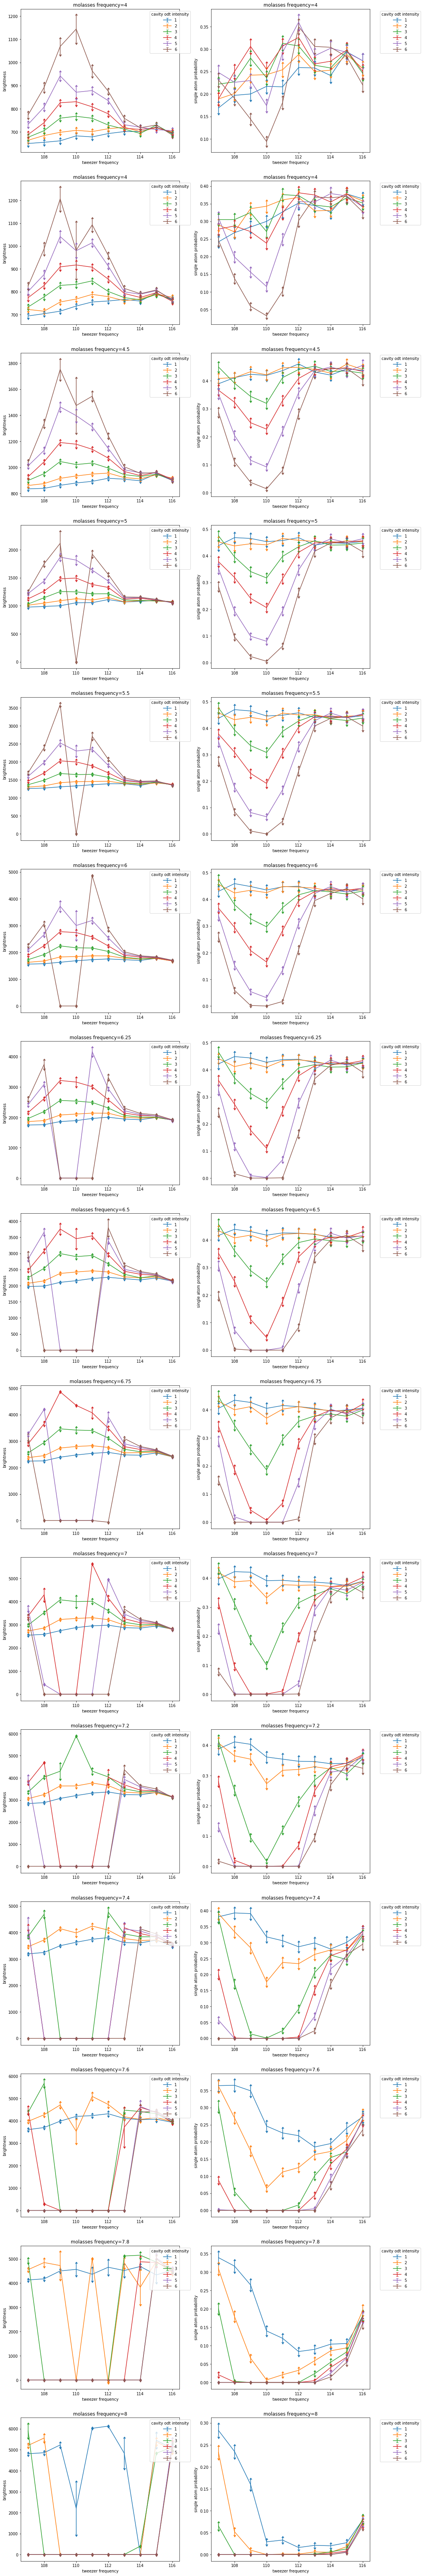

In [186]:
fig, axs = plt.subplots(len(mol_freq_list), 2,  figsize=(16, len(mol_freq_list)*8))
# fig.tight_layout() 
for mol_counter in range(len(mol_freq_list)):
    axs[mol_counter, 0].set_xlabel('tweezer frequency')
    axs[mol_counter, 0].set_ylabel('brightness')
    axs[mol_counter, 0].set_title(f'molasses frequency={mol_freq_list[mol_counter]}')
#     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
#     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for cav_odt_int_counter in range(len(cav_odt_int_list)):
        plot_value = all_brightness[mol_counter, 0, :, cav_odt_int_counter]
        plot_error = all_brightness_sigma[mol_counter, 0, :, cav_odt_int_counter]
        filtering = plot_value > -500
        axs[mol_counter, 0].errorbar(np.array(tweezer_freq_list)[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{cav_odt_int_list[cav_odt_int_counter]}')
    axs[mol_counter, 0].legend(title='cavity odt intensity', bbox_to_anchor=(0.8, 1), loc='upper left')
    axs[mol_counter, 0].tick_params(axis='y')
    
    
    axs[mol_counter, 1].set_xlabel('tweezer frequency')
    axs[mol_counter, 1].set_ylabel('single atom probability')
    axs[mol_counter, 1].set_title(f'molasses frequency={mol_freq_list[mol_counter]}')
    for cav_odt_int_counter in range(len(cav_odt_int_list)):
        plot_value = all_fidelity[mol_counter, 0, :, cav_odt_int_counter]
        plot_error = all_fidelity_sigma[mol_counter, 0, :, cav_odt_int_counter]
        filtering = plot_value > -500
        axs[mol_counter, 1].errorbar(np.array(tweezer_freq_list)[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{cav_odt_int_list[cav_odt_int_counter]}')
    axs[mol_counter, 1].legend(title='cavity odt intensity', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[mol_counter, 1].tick_params(axis='y')

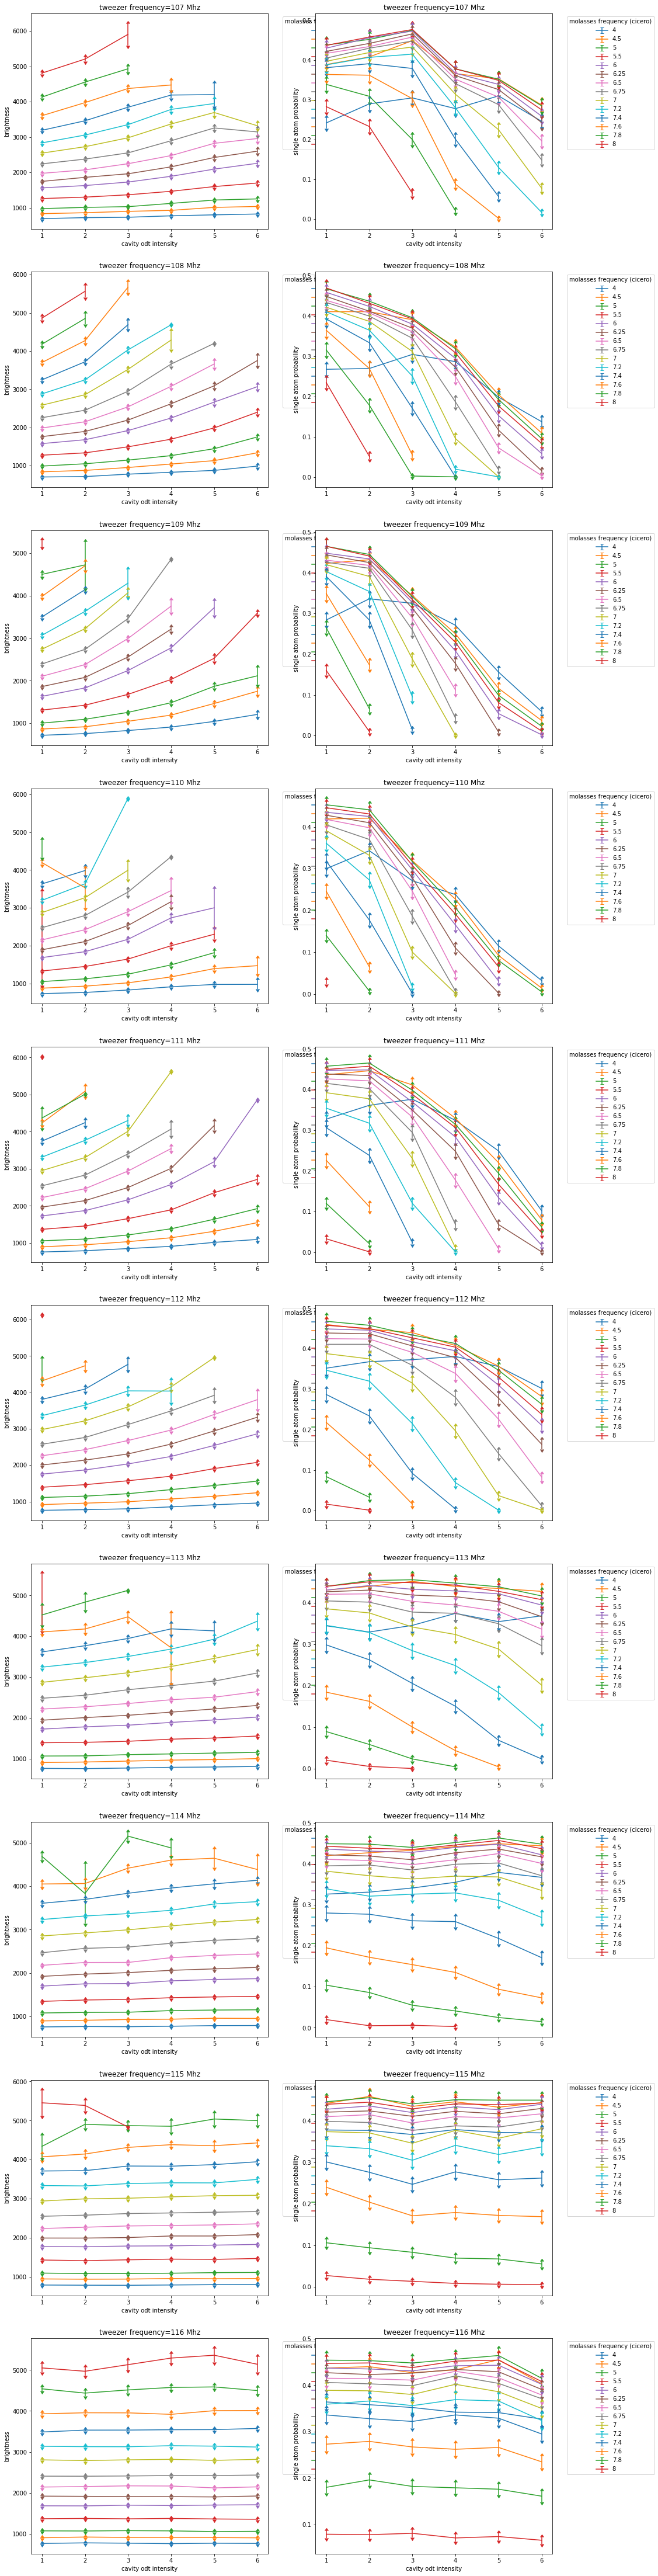

In [187]:
fig, axs = plt.subplots(len(tweezer_freq_list), 2,  figsize=(16, len(tweezer_freq_list)*8))

for tweezer_counter in range(len(tweezer_freq_list)):
    axs[tweezer_counter, 0].set_xlabel('cavity odt intensity')
    axs[tweezer_counter, 0].set_ylabel('brightness')
    axs[tweezer_counter, 0].set_title(f'tweezer frequency={tweezer_freq_list[tweezer_counter]} Mhz')
#     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
#     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for mol_counter in range(1,len(mol_freq_list)):
        plot_value = all_brightness[mol_counter, 0, tweezer_counter, :]
        plot_error = all_brightness_sigma[mol_counter, 0, tweezer_counter, :]
        filtering = plot_value > 500
        axs[tweezer_counter, 0].errorbar(np.array(cav_odt_int_list)[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    axs[tweezer_counter, 0].legend(title='molasses frequency (cicero)', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[tweezer_counter, 0].tick_params(axis='y')
    
    
    
    axs[tweezer_counter, 1].set_xlabel('cavity odt intensity')
    axs[tweezer_counter, 1].set_ylabel('single atom probability')
    axs[tweezer_counter, 1].set_title(f'tweezer frequency={tweezer_freq_list[tweezer_counter]} Mhz')
#     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
#     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for mol_counter in range(1,len(mol_freq_list)):
        plot_value = all_fidelity[mol_counter, 0, tweezer_counter, :]
        plot_error = all_fidelity_sigma[mol_counter, 0, tweezer_counter, :]
        filtering = plot_value > 0
        axs[tweezer_counter, 1].errorbar(np.array(cav_odt_int_list)[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    axs[tweezer_counter, 1].legend(title='molasses frequency (cicero)', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[tweezer_counter, 1].tick_params(axis='y')

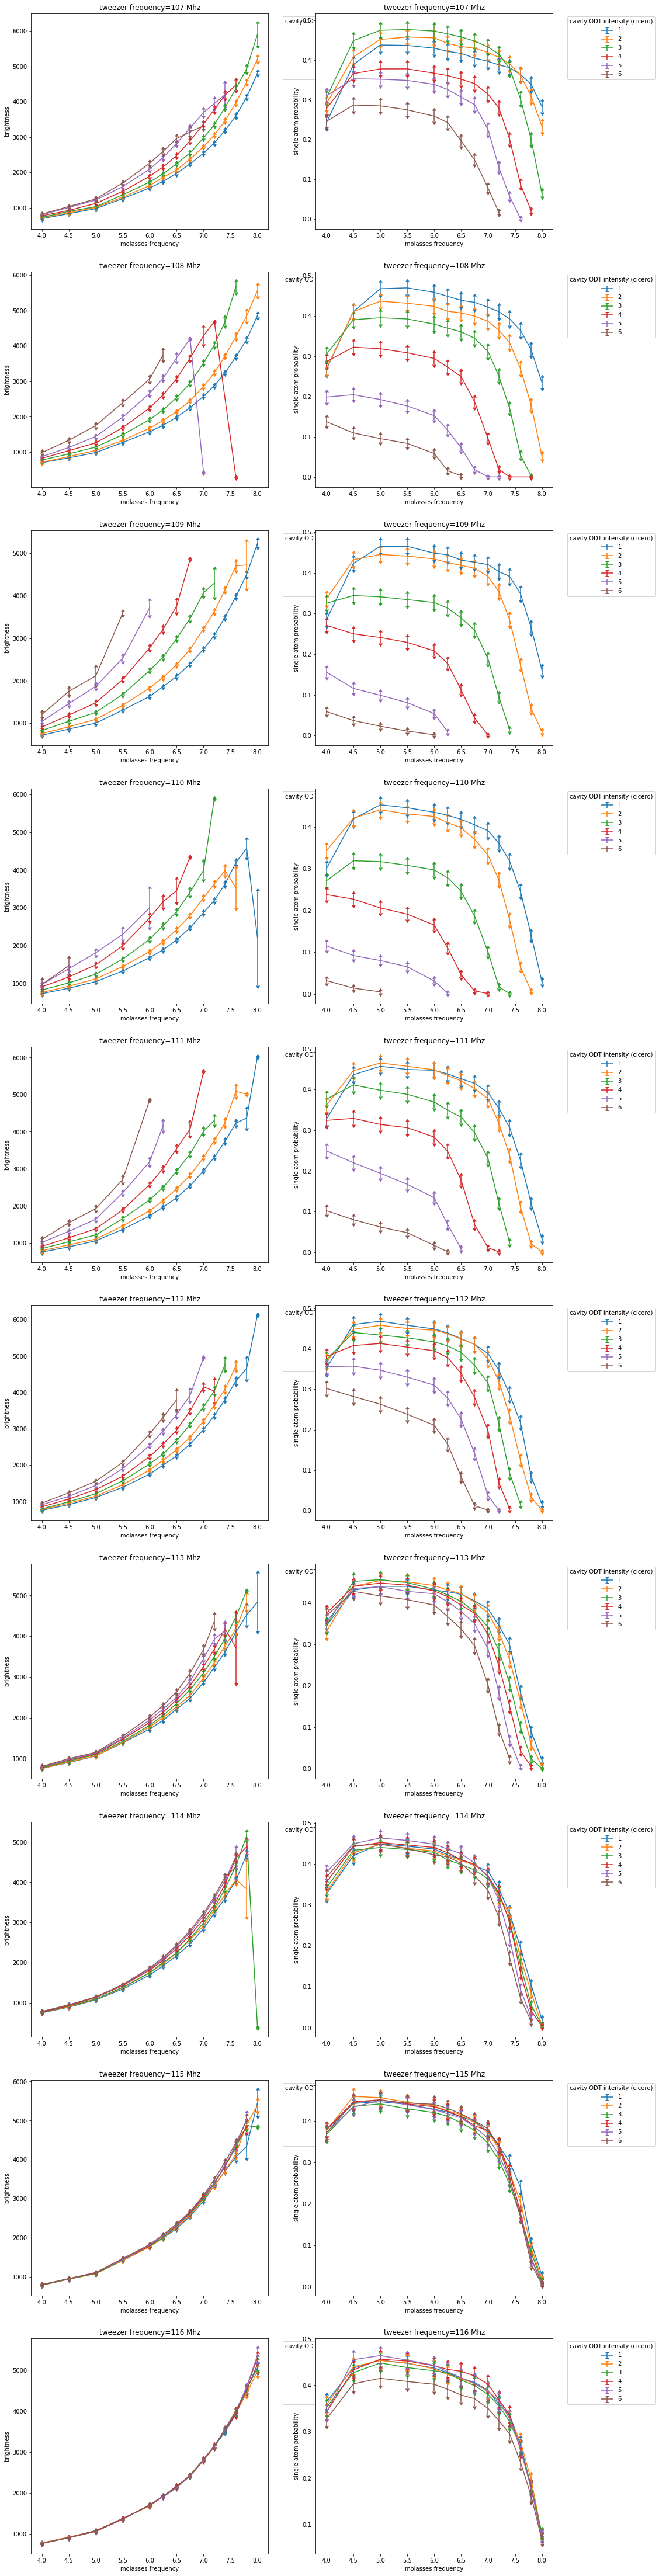

In [188]:
fig, axs = plt.subplots(len(tweezer_freq_list), 2,  figsize=(16, len(tweezer_freq_list)*8))

for tweezer_counter in range(len(tweezer_freq_list)):
    axs[tweezer_counter, 0].set_xlabel('molasses frequency')
    axs[tweezer_counter, 0].set_ylabel('brightness')
    axs[tweezer_counter, 0].set_title(f'tweezer frequency={tweezer_freq_list[tweezer_counter]} Mhz')
#     axs[cav_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[cav_counter, 0, :] , \
#     yerr = all_brightness_sigma[cav_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for cav_counter in range(len(cav_odt_int_list)):
        plot_value = all_brightness[1:, 0, tweezer_counter, cav_counter]
        plot_error = all_brightness_sigma[1:, 0, tweezer_counter, cav_counter]
        filtering = plot_value > 100
        axs[tweezer_counter, 0].errorbar(np.array(mol_freq_list[1:])[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{cav_odt_int_list[cav_counter]}')
    axs[tweezer_counter, 0].legend(title='cavity ODT intensity (cicero)', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[tweezer_counter, 0].tick_params(axis='y')
    
    
    
    axs[tweezer_counter, 1].set_xlabel('molasses frequency')
    axs[tweezer_counter, 1].set_ylabel('single atom probability')
    axs[tweezer_counter, 1].set_title(f'tweezer frequency={tweezer_freq_list[tweezer_counter]} Mhz')
#     axs[cav_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[cav_counter, 0, :] , \
#     yerr = all_brightness_sigma[cav_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for cav_counter in range(len(cav_odt_int_list)):
        plot_value = all_fidelity[1:, 0, tweezer_counter, cav_counter]
        plot_error = all_fidelity_sigma[1:, 0, tweezer_counter, cav_counter]
        filtering = plot_value > 0
        axs[tweezer_counter, 1].errorbar(np.array(mol_freq_list[1:])[filtering], plot_value[filtering], \
        yerr = plot_error[filtering],  uplims=True, lolims=True, label= f'{cav_odt_int_list[cav_counter]}')
    axs[tweezer_counter, 1].legend(title='cavity ODT intensity (cicero)', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[tweezer_counter, 1].tick_params(axis='y')

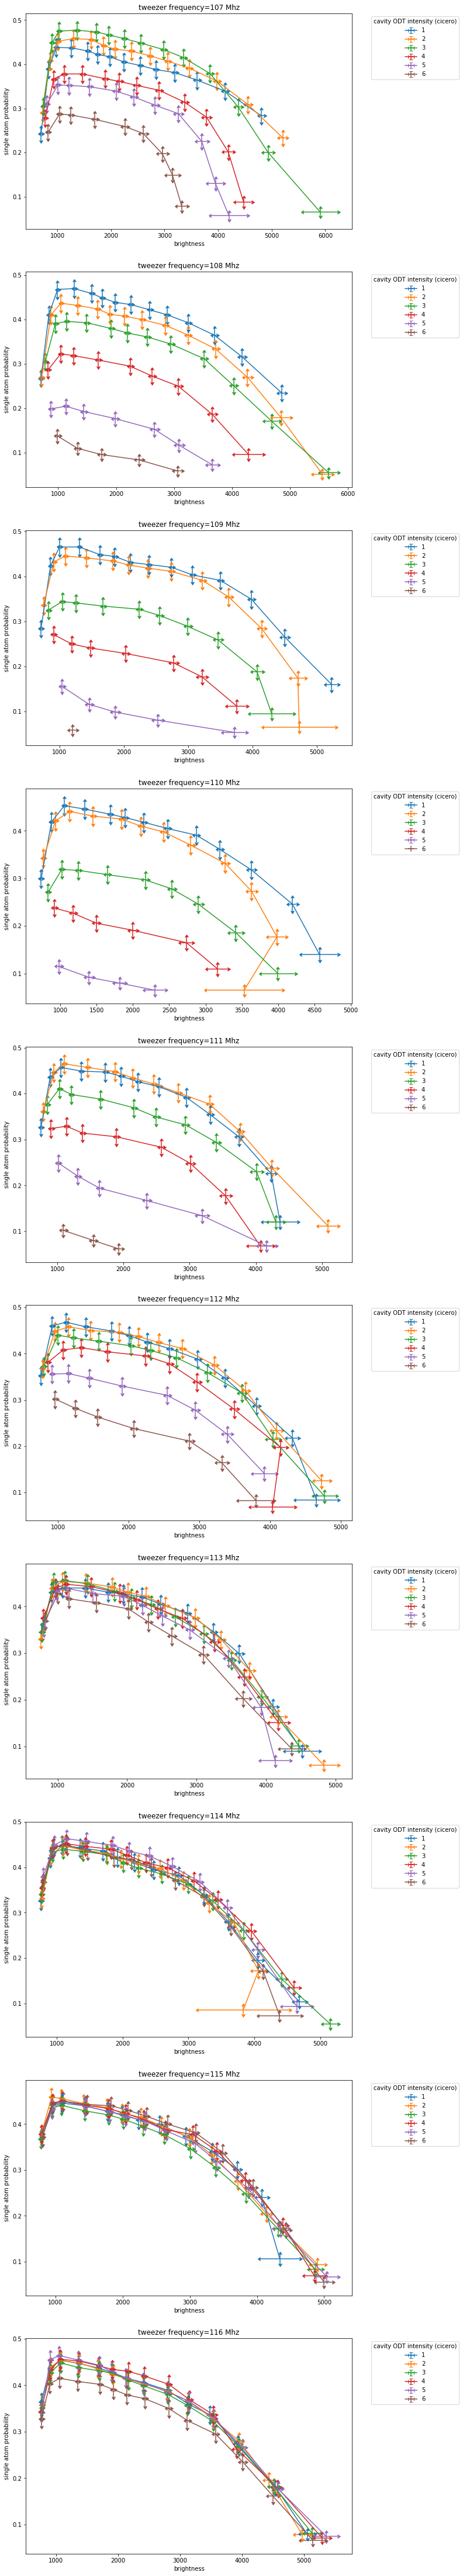

In [189]:
fig, axs = plt.subplots(len(tweezer_freq_list), 1,  figsize=(10, len(tweezer_freq_list)*8))

for tweezer_counter in range(len(tweezer_freq_list)):
    axs[tweezer_counter].set_xlabel('brightness')
    axs[tweezer_counter].set_ylabel('single atom probability')
    axs[tweezer_counter].set_title(f'tweezer frequency={tweezer_freq_list[tweezer_counter]} Mhz')
#     axs[cav_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[cav_counter, 0, :] , \
#     yerr = all_brightness_sigma[cav_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    for cav_counter in range(len(cav_odt_int_list)):
        y_plot_value = all_fidelity[1:, 0, tweezer_counter, cav_counter]
        y_plot_error = all_fidelity_sigma[1:, 0, tweezer_counter, cav_counter]
        filtering = y_plot_value > 0.05
        x_plot_value = all_brightness[1:, 0, tweezer_counter, cav_counter]
        x_plot_error = all_brightness_sigma[1:, 0, tweezer_counter, cav_counter]
        
        axs[tweezer_counter].errorbar(x_plot_value[filtering], y_plot_value[filtering], \
        xerr = x_plot_error[filtering], yerr = y_plot_error[filtering],  xuplims=True, xlolims=True, uplims=True, lolims=True, label= f'{cav_odt_int_list[cav_counter]}')
    axs[tweezer_counter].legend(title='cavity ODT intensity (cicero)', bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[tweezer_counter].tick_params(axis='y')